In [28]:
from algorithms_pca.matrix import Matrix
from algorithms_pca.linear_solver import gauss_solver
from algorithms_pca.statistics import center_data, covariance_matrix
from algorithms_pca.eigen import find_eigenvalues, find_eigenvectors
from algorithms_pca.pca import pca, explained_variance_ratio
from algorithms_pca.visualization import plot_pca_projection
from algorithms_pca.utils import auto_select_k

In [29]:
A = Matrix([[4, 7], [2, 6]])
B = Matrix([[3, 8], [5, 1]])
print("A + B =", A + B)
print("A - B =", A - B)
print("A * B (elem) =", A * B)
print("A.matmul(B) =", A.matmul(B))
print("A.T =", A.T)
print("det(A) =", A.determinant())
print("inv(A) =", A.inverse())
print("rank(A) =", A.rank())
print("trace(A) =", A.trace())
P, L, U = A.lu()
print("P, L, U =", P, L, U)
x = A.solve(Matrix([[1], [0]]))
print("Solution x to Ax=b =", x)
x = gauss_solver(A, Matrix([[1], [0]]))
print("Solution x to Ax=b =", x)

A = Matrix([[1, 2, 3], [4, 5, 6], [7, 8, 10]])
x = A.solve(Matrix([[6], [15], [25]]))
print("Solution x to Ax=b =", x)

x = gauss_solver(A, Matrix([[6], [15], [25]]))
print("Solution x to Ax=b =", x)

A = Matrix([
    [1, 2, -1],
    [-2, -4, 2],
    [3, 6, -3]
])
b = Matrix([
    [1],
    [-2],
    [3]
])

solutions = gauss_solver(A, b)
print(solutions)

A + B = Matrix([[7, 15], [7, 7]])
A - B = Matrix([[1, -1], [-3, 5]])
A * B (elem) = Matrix([[12, 56], [10, 6]])
A.matmul(B) = Matrix([[47, 39], [36, 22]])
A.T = Matrix([[4, 2], [7, 6]])
det(A) = 10.0
inv(A) = Matrix([[0.6000000000000001, -0.7000000000000001], [-0.2, 0.4]])
rank(A) = 2
trace(A) = 10
P, L, U = Matrix([[1.0, 0.0], [0.0, 1.0]]) Matrix([[1.0, 0.0], [0.5, 1.0]]) Matrix([[4, 7], [0.0, 2.5]])
Solution x to Ax=b = Matrix([[0.6000000000000001], [-0.2]])
Solution x to Ax=b = [Matrix([[0.6000000000000001], [-0.2]])]
Solution x to Ax=b = Matrix([[1.0000000000000004], [0.9999999999999987], [1.0000000000000007]])
Solution x to Ax=b = [Matrix([[1.0000000000000013], [0.9999999999999969], [1.0000000000000016]])]
[Matrix([[1.0], [0.0], [0.0]]), Matrix([[-2.0], [1.0], [0.0]]), Matrix([[1.0], [0.0], [1.0]])]


In [30]:
X = Matrix([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])

X_centered = center_data(X)
print("Центрированная матрица:")
print(X_centered)

cov = covariance_matrix(X_centered)
print("Матрица ковариаций:")
print(cov)

Центрированная матрица:
Matrix([[-3.0, -3.0, -3.0], [0.0, 0.0, 0.0], [3.0, 3.0, 3.0]])
Матрица ковариаций:
Matrix([[9.0, 9.0, 9.0], [9.0, 9.0, 9.0], [9.0, 9.0, 9.0]])


In [31]:
C = Matrix([[1, 2],
            [2, 4]])
eigenvalues = find_eigenvalues(C)
print("Eigenvalues:", eigenvalues)

eigenvectors = find_eigenvectors(C, eigenvalues)
print("Eigenvectors:")
for v in eigenvectors:
    print(v)

Eigenvalues: [-0.0, 5.0]
Eigenvectors:
Matrix([[-2.0], [1.0]])
Matrix([[0.5], [1.0]])


Projected data (n×k): Matrix([[-4.0, 0.0], [0.0, 0.0], [4.0, 0.0]])
Explained variance ratio: 1.0000
Projected data (n×k):
[[-2.82842712]
 [ 0.        ]
 [ 2.82842712]]
Explained variance ratio: 1.0000


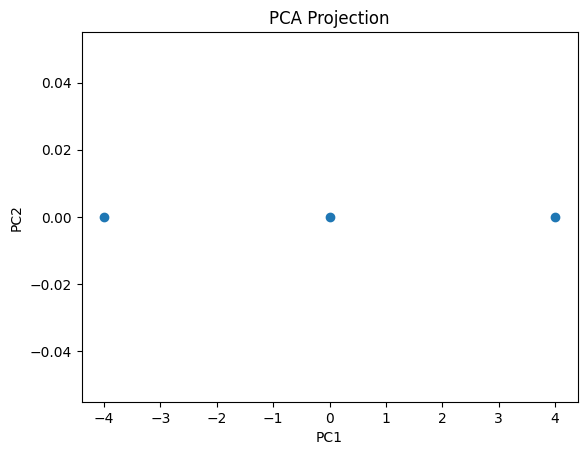

In [32]:
sample_data = Matrix([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
X_p, explained = pca(sample_data, k=2)
print(f"Projected data (n×k): {X_p}")
print(f"Explained variance ratio: {explained:.4f}")
plot_pca_projection(X_p)

import numpy as np

sample_data = np.array([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

mean = np.mean(sample_data, axis=0)
X_centered = sample_data - mean

cov_matrix = np.cov(X_centered, rowvar=False)

eigen_values, eigen_vectors = np.linalg.eigh(cov_matrix)

sorted_idx = np.argsort(eigen_values)[::-1]
eigen_vectors_sorted = eigen_vectors[:, sorted_idx]
eigen_values_sorted = eigen_values[sorted_idx]

k = 1
components = eigen_vectors_sorted[:, :k]

X_p = X_centered @ components

explained = eigen_values_sorted[:k].sum() / eigen_values_sorted.sum()

print("Projected data (n×k):")
print(X_p)
print(f"Explained variance ratio: {explained:.4f}")

In [33]:
X = Matrix([
    [2.5, 2.4, 1.2, 3.1, 0.5],
    [0.5, 0.7, 1.5, 2.9, 0.3],
    [2.2, 2.9, 0.9, 3.2, 0.6],
    [1.9, 2.2, 1.0, 3.0, 0.4],
    [3.1, 3.0, 1.3, 3.5, 0.7],
    [2.3, 2.7, 1.1, 3.3, 0.5],
])
print(eig)

eig = find_eigenvalues(covariance_matrix(center_data(X)))
auto_select_k(eig, 0.95)

[0.01906, 0.07567, 1.49594]
Eigenvalues (sorted): [np.float64(1.4959417717526826), np.float64(0.07566686547696312), np.float64(0.019063127962740137), np.float64(0.001747820127958624), np.float64(0.00024708134632266235)]
auto_select_k -> 2
